In [1]:
%load_ext autoreload
%autoreload 2

# Leakage reduction in fast superconducting qubit gates via optimal control

In this notebook we will showcase using QUA for implementing some of the work described in the paper whose name is in the title. The paper is included as a PDF in the current folder, or you can access it [via the arXiv](https://arxiv.org/abs/2003.05952).

The system under consideration is a single superconduting qubit (though there are actually two qubits and a flux tunable coupler in the device, but they are not used here). 

The goal is to optimize the shape of a short (9 ns) control pulse, such that the leakage to the qubit f state is minimized. 


<center><img src="figure_1.png"/></center>

## Optimization

The optimization used by the authors uses a [CMA-ES](https://en.wikipedia.org/wiki/CMA-ES)
optimization of the amplitudes (of both I and Q quadratures) and frequency of a [DRAG pulse](https://arxiv.org/pdf/0901.0534.pdf). This is a gradient-free optimization technique which, like the more familiar Nelder-Mead method. 
The cost function is evaluated via a randomized benchmarking (RB) procedure. 

RB is a useful technique to estimate the fidelity of quantum operations by creating a
random circuit of cliffords. The random circuit is 
followed by an operation to recover the system to the ground state. The final step of this procedure 
is a measurement which, after multiple realizations, gives an average figure of merit for the fidelity of 
all operations performed on the qubit. A randomized benchmarking procedure script is available on the QM Libraries repo on GitHub, and is repeated almost 
without changes here. 

The optimal pulse obtained is then used as a starting point for an optimization step with more degrees of freedom.
In this second step, each sample of the I and Q components of the DRAG pulse is allowed to be modified by a weight vector $\delta_n$. 
This is referred to as a _piecewise constant pulse_ (PWC). With these added degrees of freedom, the optimization is run again to obtain the final optimized pulse. 
In the paper, fidelity is calculated for different pulse durations (as a free parameter rather than an optimization parameter) to final an ideal duration. 

## QUA Implementation

The QUA side of the procedure outline above is performed in [lr_lib](lr_lib.py). This file contains 
the function `get_program` which performs two operations: generation of the I,Q slowly varying envelopes needed to 
synthesize the waveforms and randomization of the RB circuit. 

The QUA program generated by `get_program` is run by `get_result` which runs it multiple time 
to get multiple realizations at the specified RB circuit depth. The fidelity is calculated at each 
step and an error term is returned to be used as a cost for the next optimization step. 


(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=426491, Thu Apr  1 15:39:27 2021)
2021-04-01 15:39:27,883 - qm - INFO - Performing health check
2021-04-01 15:39:27,892 - qm - INFO - Health check passed
2021-04-01 15:39:27,990 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 15:39:28,123 - qm - INFO - Flags: 
2021-04-01 15:39:28,124 - qm - INFO - Simulating Qua program
2021-04-01 15:39:29,007 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 15:39:29,309 - qm - INFO - Flags: 
2021-04-01 15:39:29,311 - qm - INFO - Simulating Qua program
2021-04-01 15:39:31,754 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 15:39:31,908 - qm - INFO - Flags: 
2021-04-01 15:39:31,909 - qm - INFO - Simulating Qua program
2021-04-01 15:39:32,697 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-01 15:39:32,962 - qm - INFO - Flags: 
2021-04-01 15:39:32

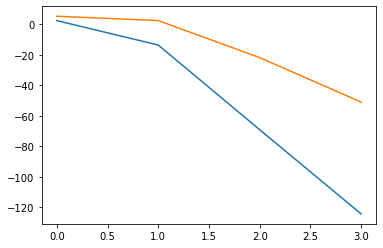

In [3]:
# !pip install cma
# !pip install http://127.0.0.1:31742/api/v1/python-package
import cma
from lr_lib import *
import numpy as np
import matplotlib.pyplot as plt
import time


##we then optimize a regular DRAG pulse
np.random.seed(3)
es1 = cma.CMAEvolutionStrategy(np.random.rand(3), 0.5)
es1.optimize(cost_DRAG)
es1.result_pretty()

##Finally, we use the optimized DRAG pulse to add more degrees of freedom
## use A, B, freq as initial guess for the full optimization
start = time.time()
init = list(es1.result.xbest) + list(np.random.rand(n_params))
sigma0 = 0.5
es2 = cma.CMAEvolutionStrategy(init, sigma0, {"popsize": 40})
es2.optimize(cost_optimal_pulse)
es2.result_pretty()
end = time.time()
print(end - start)


# We can now draw the optimal pulse
opt_pulse = np.array(get_DRAG_pulse("X/2", es2.result.xbest, pulse_duration))
plt.plot(opt_pulse[0, :])
plt.plot(opt_pulse[1, :])
